### HU Extension                  Assignment 05          E89 Deep Learning

**Problem 1.** Consider Jupyter Notebook 3.6-classifying-newswires.ipynb analyzing classification of Reuters newswires into 46 classes. Consider the model used in the notebook.

Determine the optimal number of epochs by training the model with one training set of 7982 samples and one validation set of 1000 samples.
Determine the accuracy of the model when trained with such optimal number of epochs.
(35%)

**Solution:**

Running cells from the provided *3.6-classifying-newswires.ipynb* notebook.

In [4]:
import keras
keras.__version__

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.4'

# Classifying newswires: a multi-class classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

In the previous section we saw how to classify vector inputs into two mutually exclusive classes using a densely-connected neural network. 
But what happens when you have more than two classes? 

In this section, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification". If each data point could have 
belonged to multiple categories (in our case, topics) then we would be facing a "multi-label, multi-class classification" problem.

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [5]:
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

In [6]:
len(train_data)

8982

In [8]:
len(test_data)

2246

In [24]:
len(train_labels)

8982

In [9]:
len(test_labels)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [10]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [11]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[10]])

In [12]:
decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

The label associated with an example is an integer between 0 and 45: a topic index.

In [13]:
train_labels[10]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [14]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)

# Our vectorized test data
x_test = vectorize_sequences(test_data)


To vectorize the labels, there are two possibilities: we could just cast the label list as an integer tensor, or we could use a "one-hot" 
encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". 
For a more detailed explanation of one-hot encoding, you can refer to Chapter 6, Section 1. 
In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index, e.g.:

In [15]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in action in our MNIST example:

In [16]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [17]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))


There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [18]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [19]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [20]:
len(x_val), len(y_val), len(partial_x_train), len(partial_y_train)

(1000, 1000, 7982, 7982)

Now let's train our network for 20 epochs:

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 218us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 163us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 161us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 160us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 156us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 1s 161us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 1s 159us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


Let's display its loss and accuracy curves:

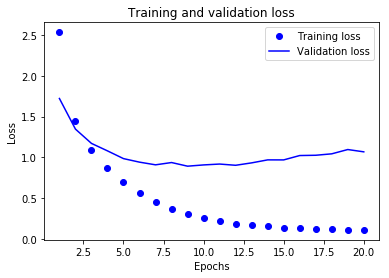

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

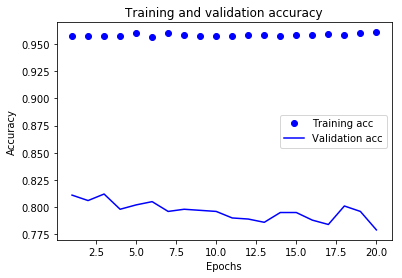

In [47]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

It seems that the network starts overfitting after 8 epochs. Let's train a new network from scratch for 8 epochs, then let's evaluate it on 
the test set:

In [24]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels, verbose = 0)

Train on 7982 samples, validate on 1000 samples
Epoch 1/8
7982/7982 [==============================] - 2s 216us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/8
7982/7982 [==============================] - 1s 161us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/8
7982/7982 [==============================] - 1s 163us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/8
7982/7982 [==============================] - 1s 159us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0539 - val_acc: 0.7590
Epoch 5/8
7982/7982 [==============================] - 1s 161us/step - loss: 0.6393 - acc: 0.8624 - val_loss: 0.9754 - val_acc: 0.7920
Epoch 6/8
7982/7982 [==============================] - 1s 161us/step - loss: 0.5124 - acc: 0.8923 - val_loss: 0.9102 - val_acc: 0.8140
Epoch 7/8
7982/7982 [==============================] - 1s 157us/step - loss: 0.4123 - acc: 0.9137 - val_loss: 0.8932 - val_acc: 0.8210
Epoch 8

In [25]:
results

[0.9847470472035191, 0.7845057880676759]


Our approach reaches an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline:

In [26]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19679430097951914

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [27]:
predictions = model.predict(x_test)

In [28]:
len(x_test)

2246

Each entry in `predictions` is a vector of length 46:

In [29]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1:

In [30]:
np.sum(predictions[0])

0.99999994

The largest entry is the predicted class, i.e. the class with the highest probability:

## A different way to handle the labels and the loss

We mentioned earlier that another way to encode the labels would be to cast them as an integer tensor, like such:

In [31]:
np.argmax(predictions[0])

3

In [32]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)


The only thing it would change is the choice of the loss function. Our previous loss, `categorical_crossentropy`, expects the labels to 
follow a categorical encoding. With integer labels, we should use `sparse_categorical_crossentropy`:

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically the same as `categorical_crossentropy`; it just has a different interface.

## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 267us/step - loss: 2.7073 - acc: 0.4411 - val_loss: 2.0155 - val_acc: 0.5930
Epoch 2/20
7982/7982 [==============================] - 2s 212us/step - loss: 1.7341 - acc: 0.6183 - val_loss: 1.6573 - val_acc: 0.6100
Epoch 3/20
7982/7982 [==============================] - 2s 210us/step - loss: 1.4678 - acc: 0.6359 - val_loss: 1.5688 - val_acc: 0.6080
Epoch 4/20
7982/7982 [==============================] - 2s 212us/step - loss: 1.3273 - acc: 0.6446 - val_loss: 1.4833 - val_acc: 0.6170
Epoch 5/20
7982/7982 [==============================] - 2s 212us/step - loss: 1.2168 - acc: 0.6498 - val_loss: 1.4540 - val_acc: 0.6250
Epoch 6/20
7982/7982 [==============================] - 2s 206us/step - loss: 1.1265 - acc: 0.6753 - val_loss: 1.4326 - val_acc: 0.6350
Epoch 7/20
7982/7982 [==============================] - 2s 210us/step - loss: 1.0522 - acc: 0.6944 - val_loss: 1.4520 - val_acc: 0.6420



Our network now seems to peak at ~71% test accuracy, a 8% absolute drop. This drop is mostly due to the fact that we are now trying to 
compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is 
too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all 
of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...
* We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers.

## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.

**Problem 2.** Run the above model with the optimal number of epochs. Determine the accuracy of the model using 4 fold validation. Model accuracy should be considered the average accuracy of all 4 training runs with one of 4 validation sets. Compare this accuracy the accuracy obtain in Problem 1.
(35%)

**Solution:**

Using page https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ as a reference I evaluated the model with the 4-fold cross-validation approach using stratified folds to keep the proportions of class labels consistent across folds.

In [40]:
from sklearn.model_selection import StratifiedKFold

seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)

cvscores = []
for i, (train, test) in enumerate(kfold.split(x_train, y_train)):
    print("Fold #", i+1,": ", len(train), "training samples, ", len(test), "validation samples.") 
    # create model
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit the model
    model.fit(x_train[train], one_hot_train_labels[train], epochs=8, batch_size=512)
    
    # evaluate the model
    scores = model.evaluate(x_train[test], one_hot_train_labels[test])
    print("Accuracy: ", scores[1], "\n")
    cvscores.append(scores[1])

print("Cross-validation accuracy: ", np.mean(cvscores))
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Fold # 1 :  6721 training samples,  2261 validation samples.
Epoch 1/8
6721/6721 [==============================] - 2s 277us/step - loss: 2.7722 - acc: 0.4642
Epoch 2/8
6721/6721 [==============================] - 1s 154us/step - loss: 1.5252 - acc: 0.6917
Epoch 3/8
6721/6721 [==============================] - 1s 157us/step - loss: 1.1177 - acc: 0.7676
Epoch 4/8
6721/6721 [==============================] - 1s 161us/step - loss: 0.8780 - acc: 0.8160
Epoch 5/8
6721/6721 [==============================] - 1s 163us/step - loss: 0.6998 - acc: 0.8536
Epoch 6/8
6721/6721 [==============================] - 1s 164us/step - loss: 0.5671 - acc: 0.8829
Epoch 7/8
6721/6721 [==============================] - 1s 157us/step - loss: 0.4548 - acc: 0.9088
Epoch 8/8
2261/2261 [==============================] - 1s 266us/step
Accuracy:  0.7823971694995218 

Fold # 2 :  6732 training samples,  2250 validation samples.
Epoch 1/8
6732/6732 [==============================] - 2s 253us/step - loss: 2.8795 - acc: 

**Problem 3.** Consider the model in Problem 1. Examine the effect of L2 regularization on the optimal number of epochs. Perform experiments with the Lambda value of 0.001, 0,005 and 0.0005. Present the dependence of the optimal number of epochs on the varying regularization parameter.
(30%)

**Solution:**

Using provided *4.4-overfitting-and-underfitting.ipynb* as a reference I train 3 more models with L2 regularization on weights of all layers with three different lambda parameters on 20 epochs.

In [36]:
from keras import regularizers

history_orig = history
history_reg = []
test_loss_and_accuracy = []
lambdas = [0.001, 0.005, 0.0005]

for llambda in lambdas:
    model = models.Sequential()
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(llambda), activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(llambda), activation='relu'))
    model.add(layers.Dense(46, kernel_regularizer=regularizers.l2(llambda), activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val))
    history_reg.append(history)
    
    test_loss_and_accuracy.append(model.evaluate(x_test, one_hot_test_labels))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 245us/step - loss: 2.8048 - acc: 0.5158 - val_loss: 1.9605 - val_acc: 0.6130
Epoch 2/20
7982/7982 [==============================] - 1s 167us/step - loss: 1.6676 - acc: 0.6862 - val_loss: 1.5315 - val_acc: 0.7040
Epoch 3/20
7982/7982 [==============================] - 1s 161us/step - loss: 1.3230 - acc: 0.7568 - val_loss: 1.3845 - val_acc: 0.7470
Epoch 4/20
7982/7982 [==============================] - 1s 165us/step - loss: 1.1336 - acc: 0.8031 - val_loss: 1.2886 - val_acc: 0.7710
Epoch 5/20
7982/7982 [==============================] - 1s 161us/step - loss: 1.0115 - acc: 0.8366 - val_loss: 1.2389 - val_acc: 0.7800
Epoch 6/20
7982/7982 [==============================] - 1s 163us/step - loss: 0.9102 - acc: 0.8613 - val_loss: 1.2230 - val_acc: 0.7960
Epoch 7/20
7982/7982 [==============================] - 1s 167us/step - loss: 0.8414 - acc: 0.8767 - val_loss: 1.1738 - val_acc: 0.8140


7982/7982 [==============================] - 1s 165us/step - loss: 0.3818 - acc: 0.9520 - val_loss: 1.0878 - val_acc: 0.8180
Epoch 20/20
2246/2246 [==============================] - 0s 205us/step


Plot training and validation accuracy and loss history versus the epochs for the original model from **problem 1** without regularization and for the 3 new models.

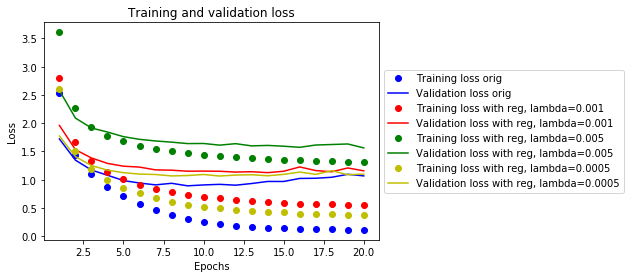

In [41]:
epochs = range(1,21)

plt.plot(epochs, history_orig.history['loss'], 'bo', label='Training loss orig')
plt.plot(epochs, history_orig.history['val_loss'], 'b', label='Validation loss orig')

plt.plot(epochs, history_reg[0].history['loss'], 'ro', label='Training loss with reg, lambda=0.001')
plt.plot(epochs, history_reg[0].history['val_loss'], 'r', label='Validation loss with reg, lambda=0.001')

plt.plot(epochs, history_reg[1].history['loss'], 'go', label='Training loss with reg, lambda=0.005')
plt.plot(epochs, history_reg[1].history['val_loss'], 'g', label='Validation loss with reg, lambda=0.005')

plt.plot(epochs, history_reg[2].history['loss'], 'yo', label='Training loss with reg, lambda=0.0005')
plt.plot(epochs, history_reg[2].history['val_loss'], 'y', label='Validation loss with reg, lambda=0.0005')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

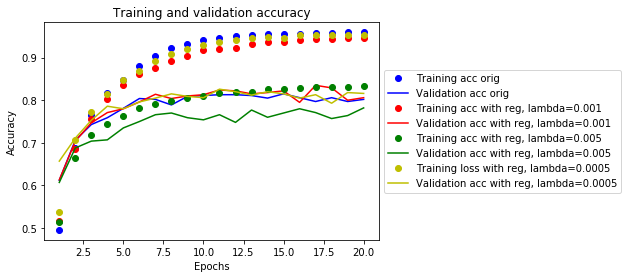

In [42]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, history_orig.history['acc'], 'bo', label='Training acc orig')
plt.plot(epochs, history_orig.history['val_acc'], 'b', label='Validation acc orig')

plt.plot(epochs, history_reg[0].history['acc'], 'ro', label='Training acc with reg, lambda=0.001')
plt.plot(epochs, history_reg[0].history['val_acc'], 'r', label='Validation acc with reg, lambda=0.001')

plt.plot(epochs, history_reg[1].history['acc'], 'go', label='Training acc with reg, lambda=0.005')
plt.plot(epochs, history_reg[1].history['val_acc'], 'g', label='Validation acc with reg, lambda=0.005')

plt.plot(epochs, history_reg[2].history['acc'], 'yo', label='Training loss with reg, lambda=0.0005')
plt.plot(epochs, history_reg[2].history['val_acc'], 'y', label='Validation acc with reg, lambda=0.0005')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Display testing results of the 3 new models:

In [43]:
test_loss_and_accuracy

[[1.251510465983716, 0.7809439002671416],
 [1.6329279030844874, 0.7609082813891362],
 [1.1812038120157677, 0.7849510240427426]]